In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyccl as ccl
import numpy as np
import healpy as hp
from scipy.interpolate import InterpolatedUnivariateSpline as IUS

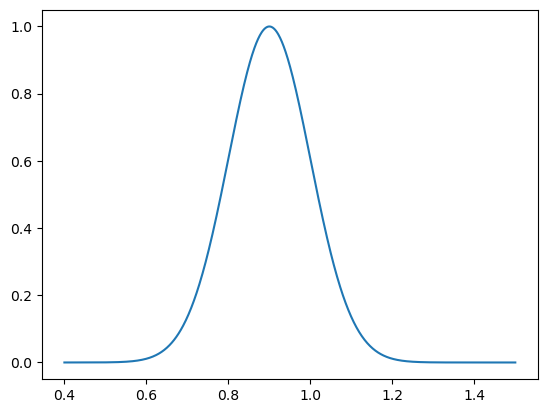

In [2]:
zs = np.linspace(0.4, 1.5, 1000)
dndz = np.exp(-(zs-0.9)**2/0.02)
plt.plot(zs,dndz)

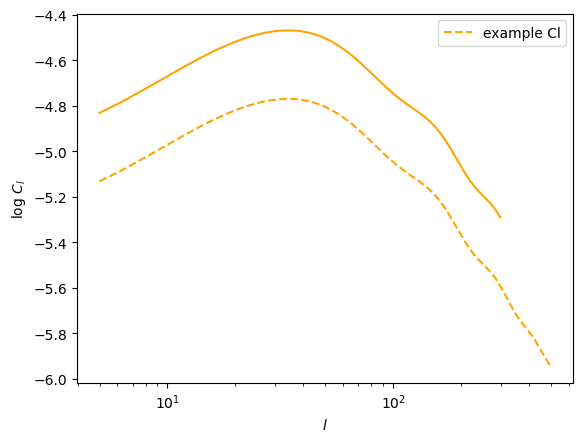

In [3]:
ells = np.arange(1000)
cosmo = ccl.Cosmology(Omega_c=0.26377065934278865, Omega_b=0.0482754208891869,
                          h=0.67556, n_s=0.9667, sigma8=0.8225, transfer_function = "boltzmann_camb")



bias1 = 1.4/cosmo.growth_factor(1/(1+zs))
bias2 = 2.8/cosmo.growth_factor(1/(1+zs))

gals = ccl.NumberCountsTracer(cosmo, has_rsd=True, dndz=(zs, dndz), bias=(zs, bias1))


#cmbk = ccl.CMBLensingTracer(cosmo, z_source=1100)
c_ells = ccl.angular_cl(cosmo, gals, gals, ells)

plt.plot(ells[5:500], np.log10(c_ells)[5:500], label = 'example Cl',color = 'orange', linestyle = '--')
plt.plot(ells[5:300], np.log10(2*c_ells)[5:300], color = 'orange', linestyle = '-')

#plt.plot(ells[1:300], np.log10(c_ells2)[1:300], color = 'black', linestyle = '-')

plt.gca().set_xscale('log')
plt.ylabel(r"log $C_l$")
plt.xlabel(r"$l$")
plt.legend()

In [4]:
def generate_density_field(cl , nside = 256, lmax=500):
    """
    Generate a HEALPix map from a given C_l spectrum.
    
    Parameters:
    cl (array): Angular power spectrum C_l
    nside (int): HEALPix nside parameter
    lmax (int, optional): Maximum l to use from the provided cl. If None, use all provided.
    
    Returns:
    array: HEALPix map of the density field
    """
    if lmax is None:
        lmax = len(cl) - 1
    
    # Generate complex a_lm with proper normalization
    alm = hp.synalm(cl, lmax=lmax, new=True)
    
    # Convert a_lm to map
    density_map = hp.alm2map(alm, nside, lmax=lmax)
    
    return density_map

In [5]:
density_field = generate_density_field(c_ells, nside=256, lmax=500)
density_field2 = 2*density_field.copy()

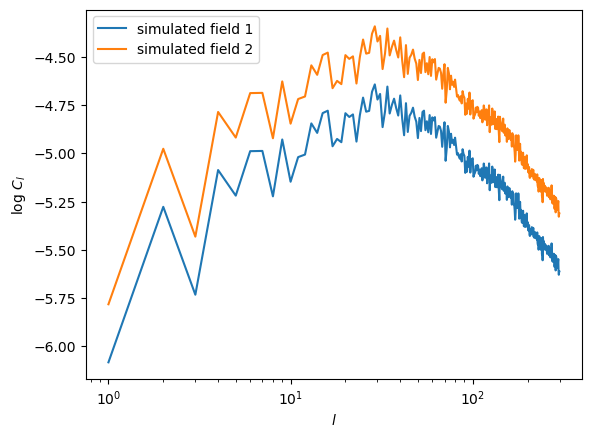

In [6]:
cl_sim = hp.anafast(density_field, lmax=1000)
cl_sim2 = hp.anafast(density_field2, lmax=1000)

plt.figure()
ell = np.arange(1000)
plt.plot(ell[1:300], np.log10(cl_sim)[1:300], label="simulated field 1")
plt.plot(ell[1:300], np.log10(2*cl_sim)[1:300], label="simulated field 2")


plt.gca().set_xscale('log')
plt.ylabel(r"log $C_l$")
plt.xlabel(r"$l$")
plt.legend()

Text(0.5, 0, '$\\ell$')

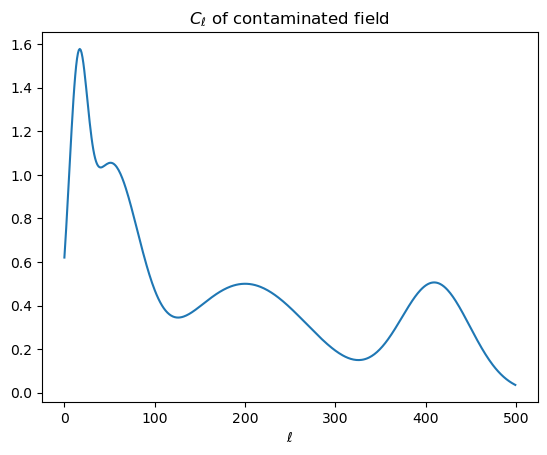

In [7]:
l = np.arange(500)
ells_comtamin = np.exp(-(l-15)**2/200)+np.exp(-(l-50)**2/2000)+0.5*np.exp(-(l-410)**2/3000)+0.5*np.exp(-(l-200)**2/10000)
plt.plot(l,ells_comtamin)
plt.title(r'$C_\ell$'+' of contaminated field')

plt.xlabel(r'$\ell$')


In [8]:
density_field_contamination = generate_density_field(ells_comtamin, nside=256, lmax=500)

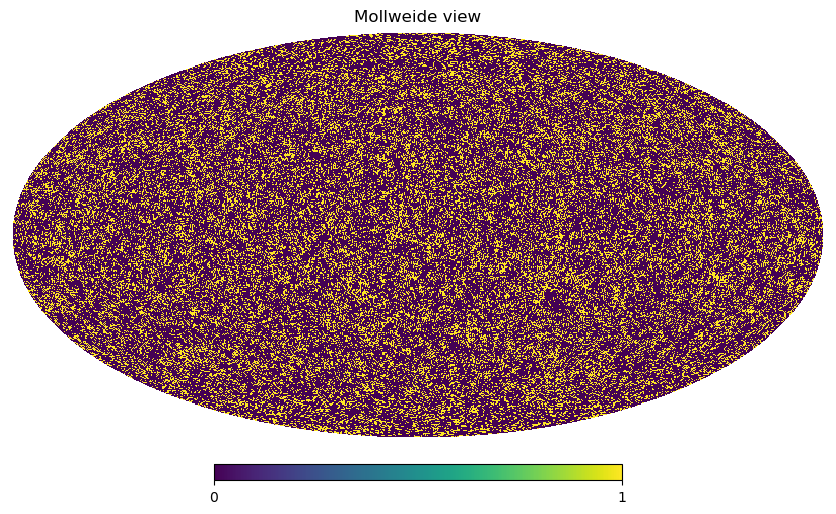

In [9]:
sign_plus = (density_field_contamination>=50).astype(int)
hp.mollview(sign_plus)

In [10]:
contamin_bins = []
for i in range(31):
    bin_i = np.percentile(density_field_contamination, i/30.*100)
    contamin_bins.append(bin_i)

In [11]:
boundary = np.median(density_field_contamination)

sign_plus = (density_field_contamination>=50)
density_field_contamed = density_field.copy()
density_field_contamed[~sign_plus] = 0 
sum_N = density_field_contamed[sign_plus].sum()
sum_area = sign_plus.sum()
ave = sum_N/sum_area
density_field_contamed[sign_plus] = density_field_contamed[sign_plus]-ave
print(ave)

density_field2_contamed = 2*density_field.copy()
density_field2_contamed[sign_plus] = 0
sum_N = density_field2_contamed[~sign_plus].sum()
#print(sum_N)
sum_area = (~sign_plus).sum()
ave2 = sum_N/sum_area
density_field2_contamed[~sign_plus] = density_field2_contamed[~sign_plus]-ave2
print(ave2)

0.0012992952134494508
-0.0008443214354996025


In [12]:
f1 = sign_plus.sum()/len(sign_plus)
f2 = (~sign_plus).sum()/len(sign_plus)
bsq = f1*1 + f2*100

In [355]:
f1

0.2705039978027344

In [13]:
boundary = np.median(density_field_contamination)

sign_plus = (density_field_contamination>=50)
density_field_contamed = density_field.copy()
density_field_contamed[~sign_plus] = 0 
sum_N = density_field_contamed[sign_plus].sum()
sum_area = sign_plus.sum()
ave = sum_N/sum_area
density_field_contamed[sign_plus] = density_field_contamed[sign_plus]-ave
print(ave)

density_field2_contamed = 2*density_field.copy()
density_field2_contamed[sign_plus] = 0
sum_N = density_field2_contamed[~sign_plus].sum()
#print(sum_N)
sum_area = (~sign_plus).sum()
ave2 = sum_N/sum_area
density_field2_contamed[~sign_plus] = density_field2_contamed[~sign_plus]-ave2
print(ave2)

f1 = sign_plus.sum()/len(sign_plus)
f2 = (~sign_plus).sum()/len(sign_plus)
bsq_12 = f1*1 + f2*4
sumfield_bias12 = density_field_contamed + density_field2_contamed
cl_bias12 = hp.anafast(sumfield_bias12, lmax=500)

sumfield_clean = np.sqrt(bsq_12)*density_field
cl_sim_clean_bias12 = hp.anafast(sumfield_clean, lmax=500)

0.0012992952134494508
-0.0008443214354996025


In [14]:
boundary = np.median(density_field_contamination)

sign_plus = (density_field_contamination>=50)
density_field_contamed = density_field.copy()
density_field_contamed[~sign_plus] = 0 
sum_N = density_field_contamed[sign_plus].sum()
sum_area = sign_plus.sum()
ave = sum_N/sum_area
density_field_contamed[sign_plus] = density_field_contamed[sign_plus]-ave
print(ave)

density_field2_contamed = 10*density_field.copy()
density_field2_contamed[sign_plus] = 0
sum_N = density_field2_contamed[~sign_plus].sum()
#print(sum_N)
sum_area = (~sign_plus).sum()
ave2 = sum_N/sum_area
density_field2_contamed[~sign_plus] = density_field2_contamed[~sign_plus]-ave2
print(ave2)

f1 = sign_plus.sum()/len(sign_plus)
f2 = (~sign_plus).sum()/len(sign_plus)

bsq_110 = f1*1 + f2*100
sumfield_bias110 = density_field_contamed + density_field2_contamed
cl_bias110 = hp.anafast(sumfield_bias110, lmax=500)

sumfield_clean = np.sqrt(bsq_110)*density_field
cl_sim_clean_bias110 = hp.anafast(sumfield_clean, lmax=500)

0.0012992952134494508
-0.00422160717749801


In [316]:
bsq_110/bsq_12

22.963895133416205

/tmp/ipykernel_2321155/2268918621.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


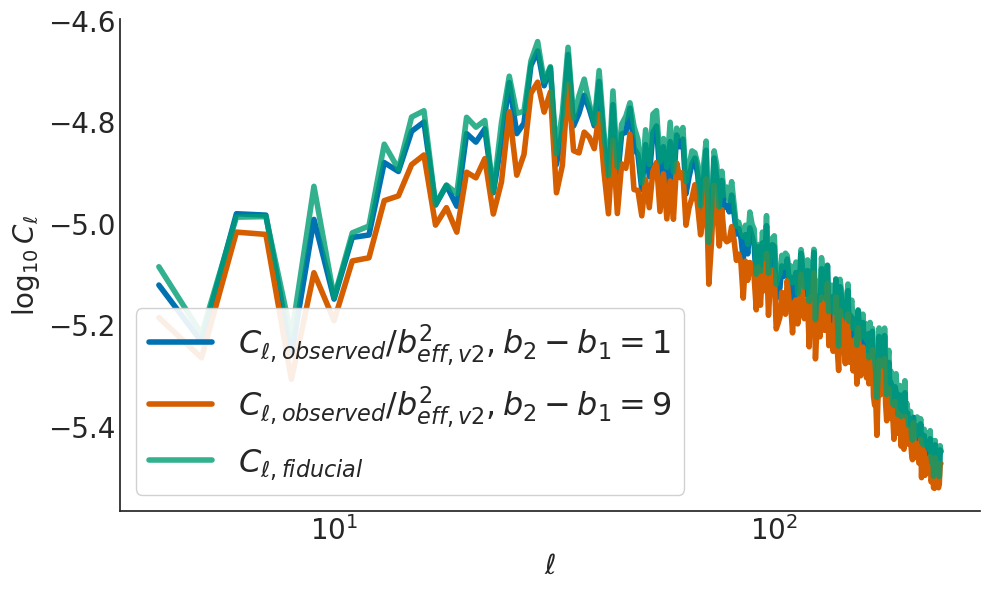

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Set the style for a clean look without grid
plt.style.use('seaborn-white')

# Create the figure with a larger size
fig, ax = plt.subplots(figsize=(10, 6))

# Define a color palette (colorblind-friendly)
colors = ['#0072B2', '#D55E00', '#009E73']

# Plot the data with improved aesthetics
ax.plot(ells[4:240], np.log10(cl_bias12/bsq_12)[4:240], 
        label=r'$C_{\ell,observed}/b_{eff,v2}^2,$'+r'$b_{2} - b_{1}=1$', linestyle='-', color=colors[0], linewidth=4)
ax.plot(ells[4:240], np.log10(cl_bias110/bsq_110)[4:240], 
        label=r'$C_{\ell,observed}/b_{eff,v2}^{2},$'+r'$b_{2} - b_{1}=9$', linestyle='-', color=colors[1], linewidth=4)
ax.plot(ells[4:240], np.log10(cl_sim_clean_bias12/bsq_12)[4:240], 
        label=r'$C_{\ell,fiducial}$', linestyle='-', color=colors[2], linewidth=4,alpha = 0.8)

# Set the scale and labels
ax.set_xscale('log')
ax.set_ylabel(r"$\log_{10} C_\ell$", fontsize=20)
ax.set_xlabel(r"$\ell$", fontsize=20)

# Customize the tick labels
ax.tick_params(axis='both', which='major', labelsize=20)

# Customize the legend
ax.legend(fontsize=23, frameon=True, fancybox=True, framealpha=0.9, loc='lower left')

# Set title
#ax.set_title("Power Spectrum Comparison", fontsize=16, pad=20)

# Remove top and right spines for a cleaner look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Adjust the layout and display
plt.tight_layout()
plt.show()

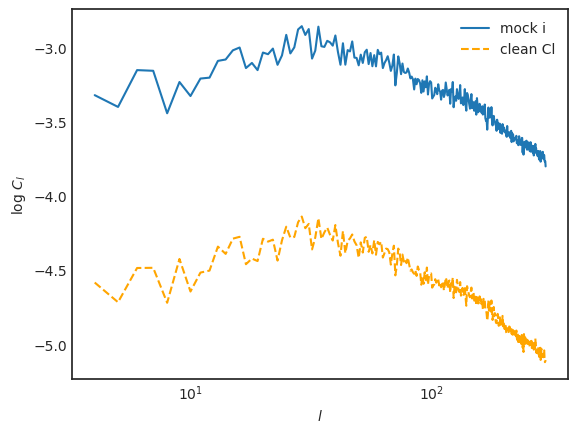

In [32]:
sumfield = density_field_contamed + density_field2_contamed
sumfield_clean = np.sqrt(bsq_12)*density_field

cl_sim2 = hp.anafast(sumfield, lmax=500)
cl_sim_clean = hp.anafast(sumfield_clean, lmax=500)

mean_cl = np.loadtxt('mean_cl.txt')
cl_i = np.loadtxt('cl_i.txt')
plt.plot(ells[4:300], np.log10(cl_sim2)[4:300], label = 'mock i')

plt.plot(ells[4:300], np.log10(cl_sim_clean)[4:300], label = 'clean Cl',color = 'orange', linestyle = '--')


plt.gca().set_xscale('log')
plt.ylabel(r"log $C_l$")
plt.xlabel(r"$l$")
plt.legend()

In [36]:
#v1: b1 = 1, b2 = 2, (b1-b2)**2 = 1
cl_v1 =  cl_bias12/bsq_12 - cl_sim_clean_bias12/bsq_12

In [51]:
bsq_12, bsq_110

(3.1924667358398438, 73.35140228271483)

In [37]:
#v1: b1 = 1, b2 = 5, (b1-b2)**2 = 16
cl_v2 = cl_bias110/bsq_110 - cl_sim_clean_bias12/bsq_12


/tmp/ipykernel_2321155/4230954784.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


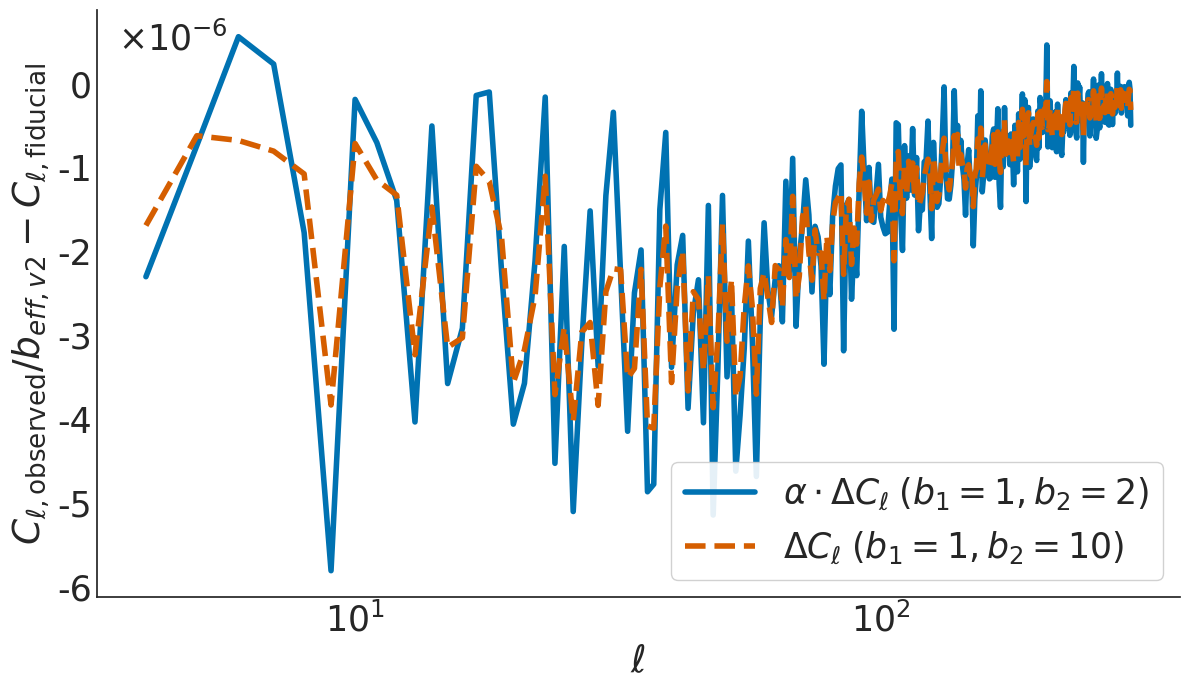

In [63]:
import matplotlib.pyplot as plt
import numpy as np

# Set the style for a clean look
plt.style.use('seaborn-white')

# Create the figure with a larger size
fig, ax = plt.subplots(figsize=(12, 7))

# Define a color palette (colorblind-friendly)
colors = ['#0072B2', '#D55E00']

alpha = 81*bsq_12/bsq_110
# Plot the data with improved aesthetics
ax.plot(ells[4:300], alpha * cl_v1[4:300], 
        label=r'$\alpha \cdot \Delta C_\ell \; (b_1 = 1, b_2 = 2)$', 
        color=colors[0], linewidth=4,linestyle = '-')
ax.plot(ells[4:300], cl_v2[4:300], 
        label=r'$\Delta C_\ell \; (b_1 = 1, b_2 = 10)$', 
        color=colors[1], linewidth=4,linestyle = '--')

# Set the scale and labels
ax.set_xscale('log')
ax.set_xlabel(r'$\ell$', fontsize=27)
#ax.set_ylabel(r'$C_{\ell, \mathrm{measured}}^{gg} - C_{\ell,\mathrm{true}}^{mm} \cdot (f_{\mathrm{sky}1}b_{1}^2 + f_{\mathrm{sky}2}b_{2}^2)$', fontsize=14)

# Customize the tick labels
ax.tick_params(axis='both', which='major', labelsize=25)

# Customize the legend
ax.legend(fontsize=25, frameon=True, fancybox=True, framealpha=0.9, loc='lower right')

# Set title
ax.set_ylabel(r'$C_{\ell, \mathrm{observed}}/b_{eff,v2} - C_{\ell,\mathrm{fiducial}} $', fontsize=27)

# Remove top and right spines for a cleaner look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add minor tick marks for x-axis
ax.xaxis.set_minor_locator(plt.LogLocator(subs=range(2, 10)))


def y_fmt(x, p):
    return f'{x*1e6:.0f}'
from matplotlib.ticker import ScalarFormatter, FuncFormatter
ax.yaxis.set_major_formatter(FuncFormatter(y_fmt))
ax.text(0.02, 0.98, r'$\times 10^{-6}$', transform=ax.transAxes, 
        verticalalignment='top', fontsize=25)
# Adjust the layout and display
plt.tight_layout()
plt.show()

In [55]:
alpha

3.5253559926006175

In [224]:
sign_plus = (density_field_contamination>=50)
win1 = sign_plus.astype(int)
win2 = (~sign_plus).astype(int)

In [225]:
sign_plus.sum()

212733

In [357]:
!pwd

/global/u2/h/huikong/desc_work


In [226]:
cl1 = hp.anafast(win1)
cl2 = hp.anafast(win2)
cl3 = hp.anafast(win1,win2)

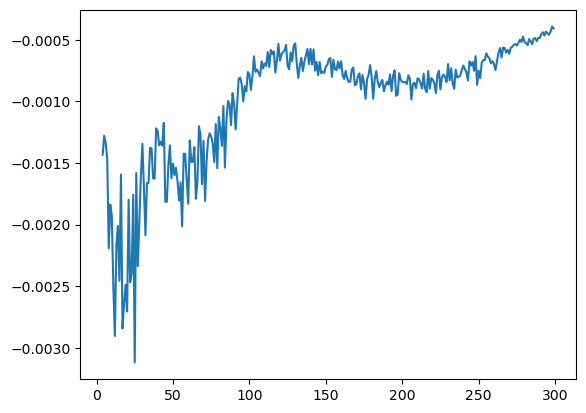

In [229]:
plt.plot(ells[4:300], -81*cl1[4:300])
#plt.plot(ells[4:300], -cl2[4:300])

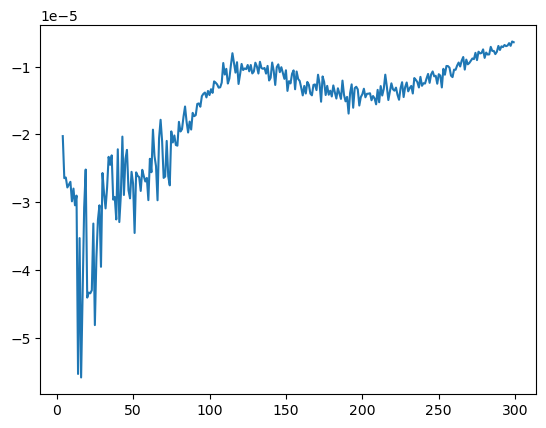

In [119]:
plt.plot(ells[4:300], cl3[4:300])

In [100]:
win1.sum()

393111

In [101]:
win2.sum()

393321

In [110]:
np.percentile(density_field_contamination, 75)

55.239001517691364